In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401

In [4]:
def wrangle(filename):
    # Open csv
    df = pd.read_csv(filename)
    
    # Drop columns with multicollineality
    df.drop(columns=["total_bedrooms", "population", "households"], inplace=True)
    
    
    return df

In [5]:
df = wrangle("California_housing.csv")
print(df.shape)
df.head()

(20640, 7)


,longitude,latitude,housing_median_age,total_rooms,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,3.8462,NEAR BAY,342200


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   median_income       20640 non-null  float64
 5   ocean_proximity     20640 non-null  object 
 6   median_house_value  20640 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 1.1+ MB


In [7]:
df.isnull().sum() / len(df)

longitude             0.0
latitude              0.0
housing_median_age    0.0
total_rooms           0.0
median_income         0.0
ocean_proximity       0.0
median_house_value    0.0
dtype: float64

In [8]:
# Check low and high cardinal categorical data
df.select_dtypes("object").nunique()

ocean_proximity    5
dtype: int64

In [9]:
# check multicollineality among numerical data
corr=df.select_dtypes("number").drop(columns="median_house_value").corr()
corr

,longitude,latitude,housing_median_age,total_rooms,median_income
longitude,1.000000,-0.924664,-0.108197,0.044568,-0.015176
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.079809
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.119034
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.198050
median_income,-0.015176,-0.079809,-0.119034,0.198050,1.000000


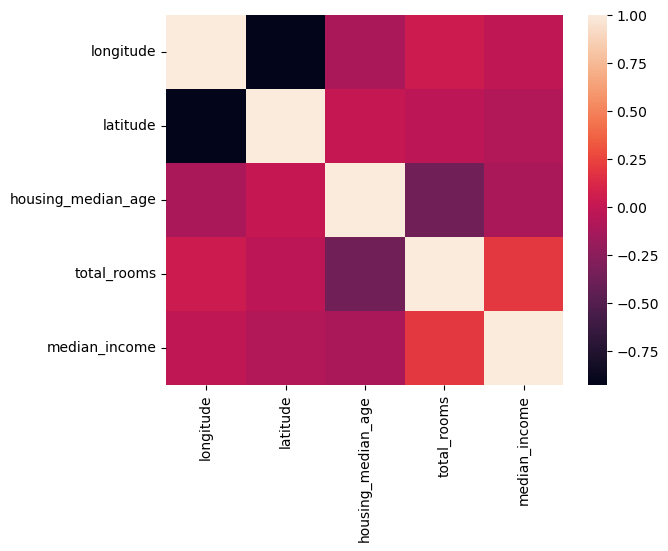

In [10]:
# use seaborn to plot matrix correllation heatmap
sns.heatmap(corr);

In [11]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,3.8462,NEAR BAY,342200


In [12]:
# Split the data into features and target
target = "median_house_value"
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "median_income", "ocean_proximity" ]

X = df[features]
y=df[target]

print("Features:", X.shape)
print("target:", y.shape)

Features: (20640, 6)
target: (20640,)


In [13]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,median_income,ocean_proximity
0,-122.23,37.88,41,880,8.3252,NEAR BAY
1,-122.22,37.86,21,7099,8.3014,NEAR BAY
2,-122.24,37.85,52,1467,7.2574,NEAR BAY
3,-122.25,37.85,52,1274,5.6431,NEAR BAY
4,-122.25,37.85,52,1627,3.8462,NEAR BAY


In [14]:
# Split data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print("X train:", X_train.shape)
print("X test:", X_test.shape)
print("y train:", y_train.shape)
print("y test:", y_test.shape)

X train: (16512, 6)
X test: (4128, 6)
y train: (16512,)
y test: (4128,)


In [15]:
len(X_train + X_test) == len(X)

True

In [16]:
# Determine the y_train mean
y_train_mean = y_train.mean()

In [17]:
# Get the Baseline Mean Absolute Error
y_pred_baseline = [y_train_mean] * len(y_train)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Baseline MAE: 90766.7453092313


In [18]:
# Instantiate Onehotencoder
ohe = OneHotEncoder()
ohe.fit(X_train)
XT_train = ohe.transform(X_train)

In [19]:
# Build Model
model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    Ridge()
)

# fit model with features and target training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('ridge', Ridge())])

In [20]:
#Predict using the training features and determine the mean absolute error
y_pred_training = model.predict(X_train) 
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 28360.67315409678


In [21]:
# Make prediction with the test data and determine the mean absolute error
y_pred_test = pd.Series(model.predict(X_test))
MAE_Test = mean_absolute_error(y_test, y_pred_test)
print(f"Test MAE:", round(MAE_Test, 2))

Test MAE: 65643.95


In [22]:
# Build a prediction that takes in all the values
def make_prediction(longitude, latitude, housing_median_age, total_rooms, median_income, ocean_proximity):
    data = {
        "longitude": longitude,
        "latitude":  latitude,
        "housing_median_age": housing_median_age,
        "total_rooms": total_rooms,
        "median_income": median_income,
        "ocean_proximity": ocean_proximity
    }

    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted Mean Price: ${prediction}"

In [23]:
# Test the predict function 
make_prediction(-122.22, 37.86, 21, 100, 8.3040, "ISLAND" )

'Predicted Mean Price: $337837.39'

In [24]:
# Test the predict function (2)
make_prediction(-122.22, 37.86, 21, 100, 8.3040, "NEAR OCEAN" )

'Predicted Mean Price: $302013.44'

In [25]:
# Test the predict function (3)
make_prediction(-122.22, 37.86, 21, 100, 8.3040, "NEAR BAY" )

'Predicted Mean Price: $237869.9'

In [26]:
# Build an interactive function table that takes in all the features with widget
interact(
    make_prediction,   
    longitude=FloatSlider(
        min=X_train["longitude"].min(),
        max=X_train["longitude"].max(),
        step=0.01,
        value=X_train["longitude"].mean(),
    ),
    latitude=FloatSlider(
        min=X_train["latitude"].min(),
        max=X_train["latitude"].max(),
        step=0.01,
        value=X_train["latitude"].mean(),
    ),
    housing_median_age=FloatSlider(
        min=X_train["housing_median_age"].min(),
        max=X_train["housing_median_age"].max(),
        step=0.01,
        value=X_train["housing_median_age"].mean(),
    ),

    total_rooms=FloatSlider(
        min=X_train["total_rooms"].min(),
        max=X_train["total_rooms"].max(),
        step=0.01,
        value=X_train["total_rooms"].mean()
    ),

    median_income=FloatSlider(
        min=X_train["median_income"].min(),
        max=X_train["median_income"].max(),
        step=0.01,
        value=X_train["median_income"].mean()
   ),

    ocean_proximity=Dropdown(options=sorted(X_train["ocean_proximity"].unique())),
);

interactive(children=(FloatSlider(value=-119.5765370639535, description='longitude', max=-114.31, min=-124.35,…